In [53]:
%matplotlib inline
import seaborn as sns
import numpy as np

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import re
import os

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

from umap import UMAP

<h2>SKIP</h2>

In [ ]:
regex = re.compile('[^а-яa-z]')

def clean(filename):
    data = pd.read_csv(filename).drop('Unnamed: 0', axis = 1)
    data = data.dropna(subset=['last_name'])
    data = data[data.last_name.map(lambda x: isinstance(x, str))]
    if data.shape[0] > 0:
        data.last_name = data.last_name.map(lambda x: regex.sub('', x.lower().split(' ')[0].split('-')[0]))
#         surnames = set(data.last_name.unique())
        surnames_with_counters = data.last_name.value_counts()
        return surnames_with_counters


path = '../data/vkdata/'
# full_surnames = set()
stats = pd.Series()
for filename in tqdm(os.listdir(path)):
    try:
        local_stats = clean(path+filename)
        stats = stats.add(local_stats,fill_value=0)
    except:
        pass
#     full_surnames.update(surnames)   

<h2>Continue</h2>

In [2]:
all_letters = 'abcdefghijklmnopqrstuvwxyzйцукенгшщзхъфывапролджэячсмитьбюё'
n_letters = len(all_letters) + 1 # Plus EOS marker

In [3]:
surnames = pd.read_csv('../data/all_surnames.csv', header = None, index_col = 0).iloc[1:]
surnames.head()
n_categories = 0

In [4]:
surnames[1][surnames[1].index.map(lambda x: type(x)==float)]

0
NaN    3308.0
NaN    1661.0
Name: 1, dtype: float64

In [5]:
surnames[1].sort_values().tail()

0
смирнова     567310.0
петрова      695579.0
петров       866018.0
иванова     1606019.0
иванов      2099133.0
Name: 1, dtype: float64

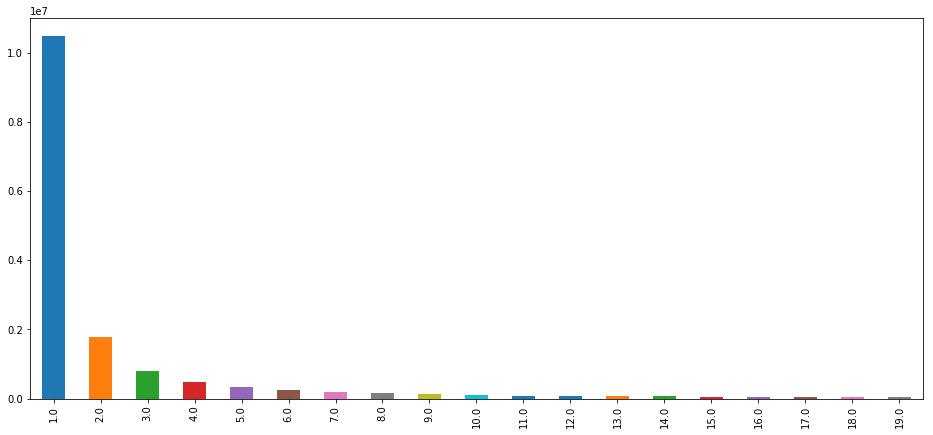

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,7))    
surnames[1][surnames[1]<20].value_counts().plot(kind = 'bar')

Creating the Network
====================

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
#         input_combined = torch.cat((category, input, hidden), 1)
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

In [8]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample(line):
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

Training the Network
--------------------

In [9]:
def train(rnn, input_line_tensor, target_line_tensor, learning_rate = 0.0005, criterion = nn.NLLLoss()):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i].to(device), hidden.to(device))
        l = criterion(output.to(device), target_line_tensor[i].to(device))
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

<h2>Training different models</h2>

In [10]:
def uniform(x):
    return 1.


def model_train(shift = 4, n_iters = 100000, f = uniform, embed_size = 20):
    cut_surnames = surnames[1][surnames[1]>shift]
    cut_surnames = cut_surnames.apply(f)
    cut_surnames = cut_surnames/ cut_surnames.sum()
    rnn = RNN(n_letters, embed_size, n_letters).to(device)
    plot_every = n_iters/100
    cur_loss = []
    total_loss = 0 # Reset every plot_every iters
    training_examples = np.random.choice(cut_surnames.index, n_iters, p=cut_surnames)
    for iter in tqdm(range(1, n_iters + 1)):
        output, loss = train(rnn, *randomTrainingExample(str(training_examples[iter-1])))
        total_loss += loss
        if iter % plot_every == 0:
            cur_loss.append(total_loss / plot_every)
            total_loss = 0
    torch.save(rnn, '../models/{}_last_name.pytorch'.format(f.__name__))
    return cur_loss, rnn

In [11]:
losses, model = {}, {} 
for f in tqdm([uniform, np.log2, np.sqrt]):
    losses[f.__name__], model[f.__name__] = model_train(f = f, n_iters = 100000)

/home/justm/Projects/Smart/env/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Plotting the Losses
-------------------

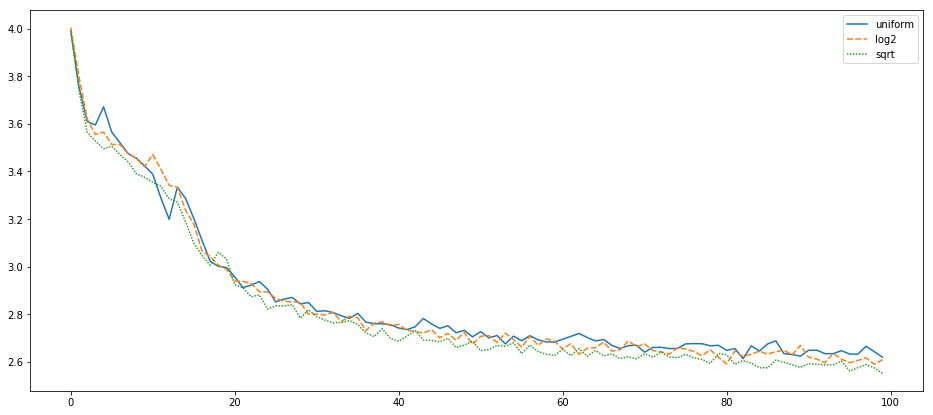

In [12]:
plt.figure(figsize=(16,7))
ax = sns.lineplot(data=pd.concat([pd.Series(losses[key]).rename(key) for key in losses.keys()], axis=1))

Making Predictions
====================

In [13]:
def hook(module, input, output):
    outputs.append(output)
        
def get_embedding(my_model, word, kek):
    with torch.no_grad():
        char = word[0]
        hidden = my_model.initHidden()
        for i in range(len(word)):
            input = inputTensor(word[i])
            output, hidden = my_model(input[0].to(device), hidden.to(device))
            topv, topi = output.topk(1)
            topi = topi[0][0]
    kek[word] = outputs[-1][0]
    
def get_embeddings(my_model, words):
    kek = {}
    for word in words:
        get_embedding(my_model, word, kek)
    return kek


for name in model:
    outputs= []
    model[name].i2h.register_forward_hook(hook)
    kek = get_embeddings(model[name], ["семёнов", "плесков", "кузин", "новичок", "грандмастер"])
    dist = {}
    for key1 in kek.keys():
        dist[key1] = [torch.dist(kek[key1], kek[key2]).cpu().numpy() for key2 in kek.keys()]
    dist = pd.DataFrame(dist)
    dist.index = dist.columns
    print(name)
    print(dist)

uniform
                семёнов     плесков      кузин     новичок грандмастер
семёнов             0.0  0.37687463  1.2966087   1.5474983   1.3398905
плесков      0.37687463         0.0   1.309675   1.4638064   1.1279249
кузин         1.2966087    1.309675        0.0    2.000143    1.670833
новичок       1.5474983   1.4638064   2.000143         0.0  0.96609557
грандмастер   1.3398905   1.1279249   1.670833  0.96609557         0.0
log2
               семёнов    плесков      кузин    новичок грандмастер
семёнов            0.0  0.5156836  1.6971272  1.8794411   1.9607216
плесков      0.5156836        0.0  1.6794474  1.6782436   1.7690315
кузин        1.6971272  1.6794474        0.0  2.5272734    2.674421
новичок      1.8794411  1.6782436  2.5272734        0.0   1.2939749
грандмастер  1.9607216  1.7690315   2.674421  1.2939749         0.0
sqrt
               семёнов    плесков      кузин    новичок грандмастер
семёнов            0.0  0.4966651   1.909784  1.7611151   1.9388573
плесков     

<h1>Clustering</h1>

In [14]:
test = pd.read_csv('../rofl/surnames.csv')
test.surname = test.surname.apply(lambda x: x.lower())
print(test.shape[0])
test.head()

346


,surname,ethnicity
0,иванов,russian
1,смирнов,russian
2,кузнецов,russian
3,попов,russian
4,васильев,russian


In [15]:
test.ethnicity.value_counts()

russian     150
german      146
georgian     50
Name: ethnicity, dtype: int64

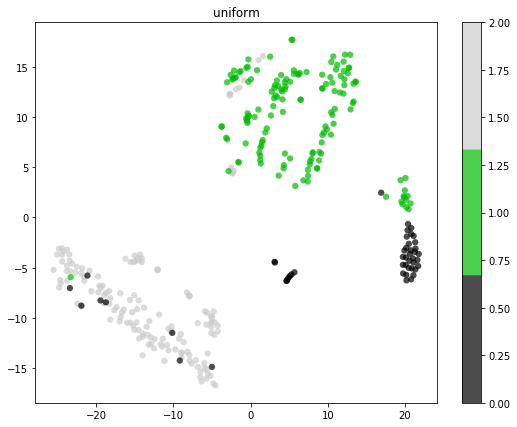

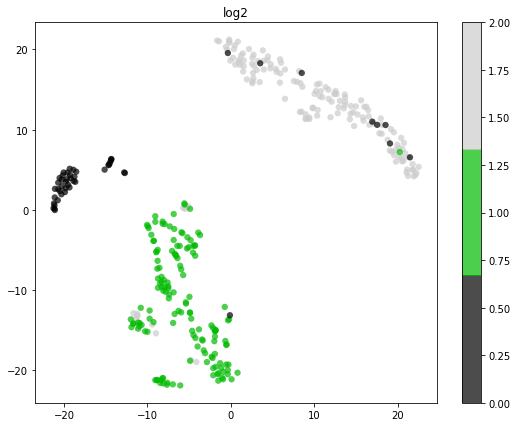

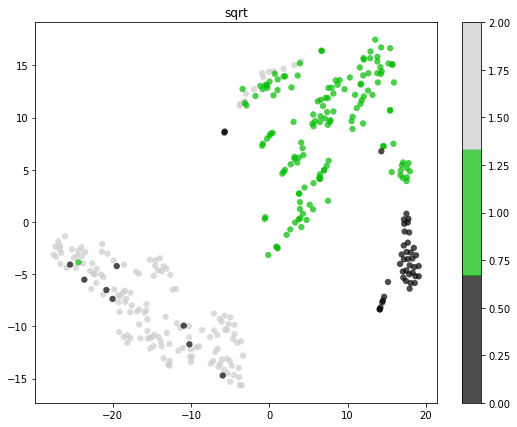

In [18]:
for name in tqdm(model):
    outputs= []
    model[name].i2h.register_forward_hook(hook)
    kek = get_embeddings(model[name], test.surname)
    kek = pd.DataFrame(kek).T
    tsne = TSNE(n_components=2, random_state=1)
    lb = LabelEncoder()
    X_tsne = tsne.fit_transform(kek)
    plt.figure(figsize=(9,7))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=lb.fit_transform(test.ethnicity), 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 3))
    plt.colorbar()
    plt.title(name)

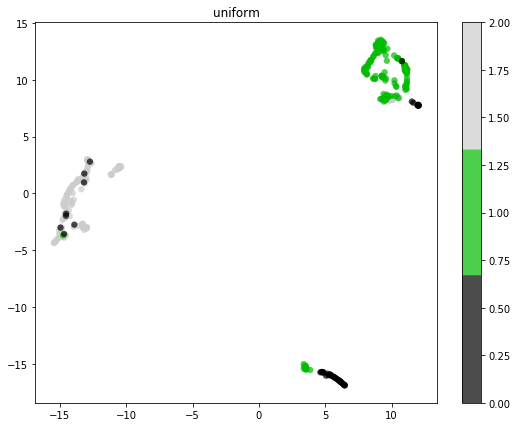

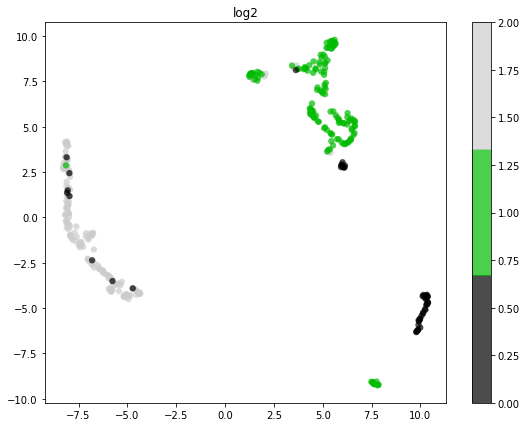

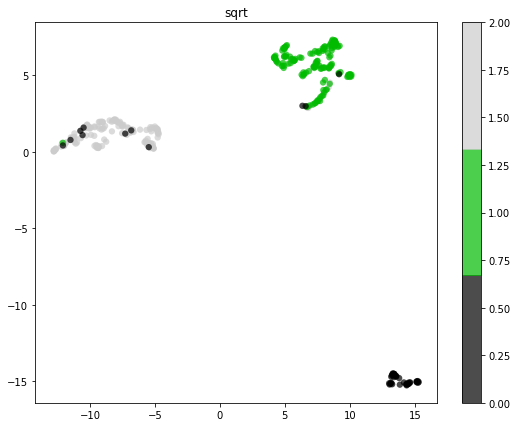

In [23]:
for name in tqdm(model):
    outputs= []
    model[name].i2h.register_forward_hook(hook)
    kek = get_embeddings(model[name], test.surname)
    kek = pd.DataFrame(kek).T
    umap_vect = UMAP()
    lb = LabelEncoder()
    X_umap = umap_vect.fit_transform(kek)
    plt.figure(figsize=(9,7))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=lb.fit_transform(test.ethnicity), 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 3))
    plt.colorbar()
    plt.title(name)

<h1>shift = 2500</h1>

In [78]:
%%time
cut_surnames = surnames[1][surnames[1]>2500]
name = 'sqrt'
outputs= []
model[name].i2h.register_forward_hook(hook)
kek = get_embeddings(model[name], cut_surnames.index.map(lambda x: str(x)))
kek = pd.DataFrame(kek).T

CPU times: user 40.9 s, sys: 4.46 s, total: 45.4 s
Wall time: 45.4 s


0 2.050528536492948


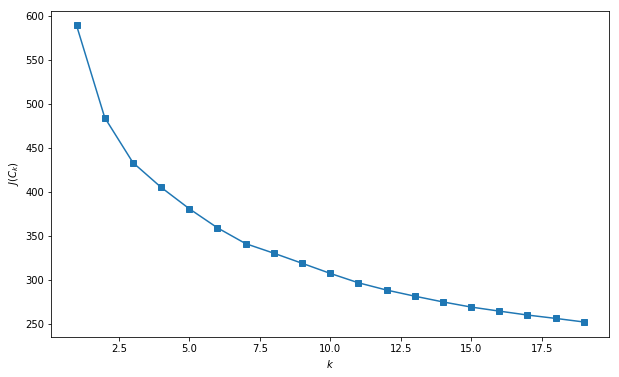

In [79]:
scaler = StandardScaler()
X = scaler.fit_transform(kek)
inertia = []
for k in tqdm(range(1,20)):
    kmeans = KMeans(n_clusters=k, random_state=57).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

second_derivative = np.diff(inertia)/np.roll(np.diff(inertia), -1)
print(second_derivative.argmax(), second_derivative.max())

In [55]:
%%time
ac = AgglomerativeClustering(n_clusters = 2).fit(X)

CPU times: user 6.63 s, sys: 642 ms, total: 7.27 s
Wall time: 7.26 s


CPU times: user 26.4 s, sys: 24.9 s, total: 51.2 s
Wall time: 17.4 s


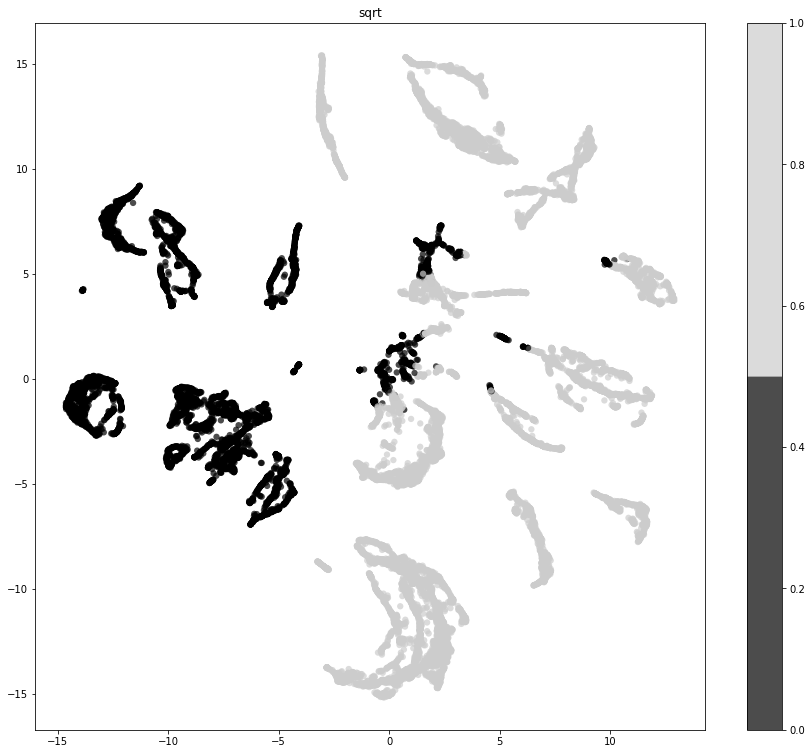

In [61]:
%%time
umap_vect = UMAP()
X_umap = umap_vect.fit_transform(X)
plt.figure(figsize=(15,13))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=ac.labels_, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.title(name)

<h1>shift = 500</h1>

In [62]:
%%time
cut_surnames = surnames[1][surnames[1]>500]
name = 'sqrt'
outputs= []
model[name].i2h.register_forward_hook(hook)
kek = get_embeddings(model[name], cut_surnames.index.map(lambda x: str(x)))
kek = pd.DataFrame(kek).T

CPU times: user 2min 57s, sys: 20.7 s, total: 3min 18s
Wall time: 3min 18s



1 2.133802208352628


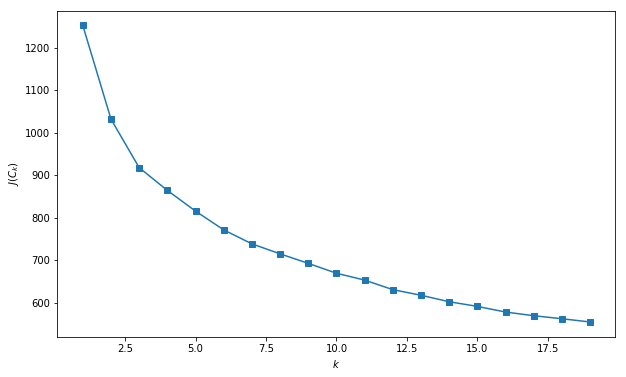

In [63]:
scaler = StandardScaler()
X = scaler.fit_transform(kek)
inertia = []
for k in tqdm(range(1,20)):
    kmeans = KMeans(n_clusters=k, random_state=57).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

second_derivative = np.diff(inertia)/np.roll(np.diff(inertia), -1)
print(second_derivative.argmax(), second_derivative.max())

In [64]:
%%time
ac = AgglomerativeClustering(n_clusters = 3).fit(X)

CPU times: user 3min 29s, sys: 12.1 s, total: 3min 41s
Wall time: 3min 40s


CPU times: user 7min 35s, sys: 3min 45s, total: 11min 20s
Wall time: 1min 47s


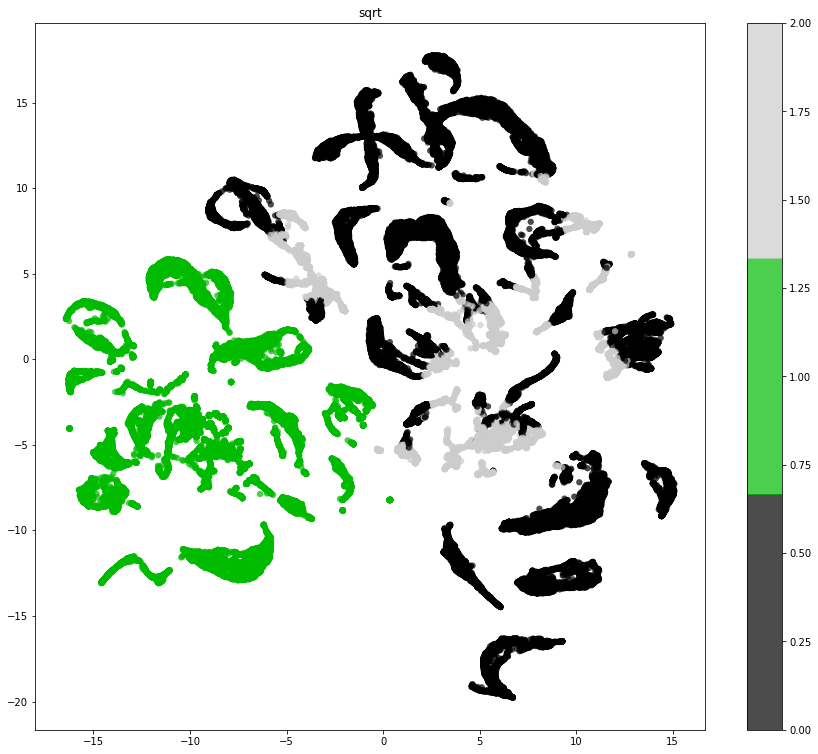

In [65]:
%%time
umap_vect = UMAP()
X_umap = umap_vect.fit_transform(X)
plt.figure(figsize=(15,13))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=ac.labels_, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.colorbar()
plt.title(name)

<h1>shift = 100</h1>

In [66]:
%%time
cut_surnames = surnames[1][surnames[1]>100]
name = 'sqrt'
outputs= []
model[name].i2h.register_forward_hook(hook)
kek = get_embeddings(model[name], cut_surnames.index.map(lambda x: str(x)))
kek = pd.DataFrame(kek).T

CPU times: user 11min 18s, sys: 1min 18s, total: 12min 36s
Wall time: 12min 36s


1 2.2465228537753523


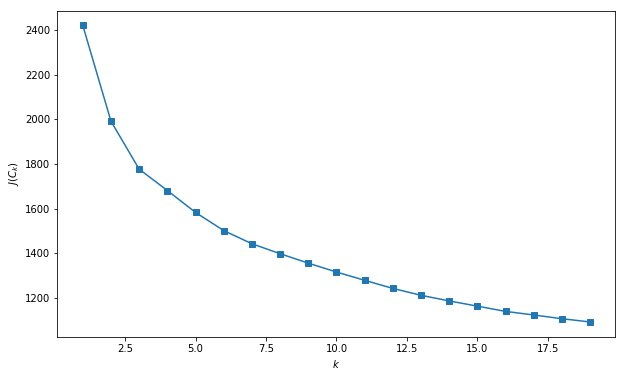

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(kek)
inertia = []
for k in tqdm(range(1,20)):
    kmeans = KMeans(n_clusters=k, random_state=57).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

second_derivative = np.diff(inertia)/np.roll(np.diff(inertia), -1)
print(second_derivative.argmax(), second_derivative.max())

In [76]:
%%time
kmeans = KMeans(n_clusters=3, random_state=57).fit(X)

CPU times: user 7.16 s, sys: 13 s, total: 20.1 s
Wall time: 3.36 s


/home/justm/Projects/Smart/env/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


CPU times: user 2h 19min 35s, sys: 1h 2min 23s, total: 3h 21min 59s
Wall time: 15min 17s


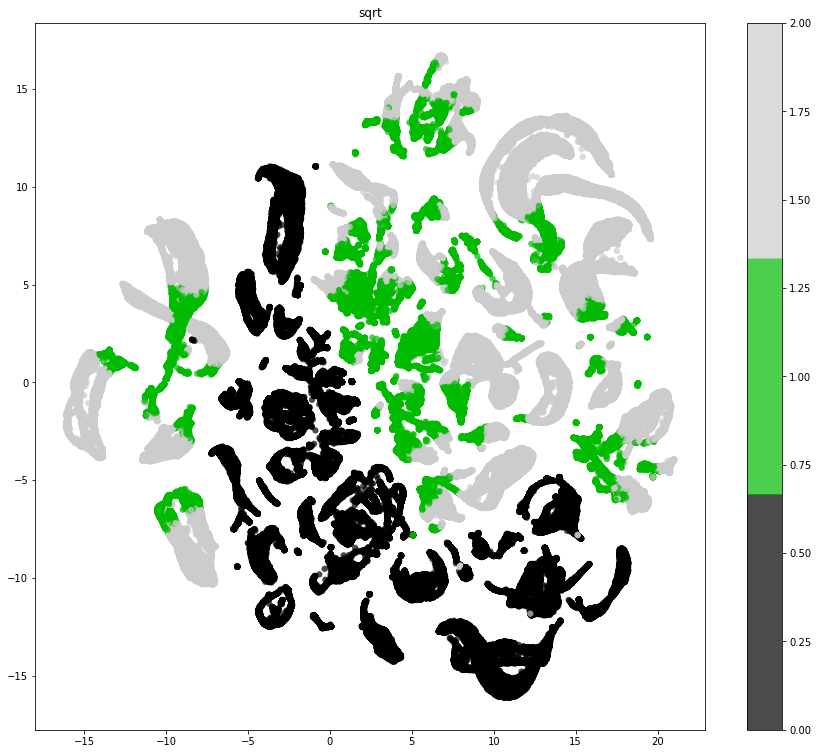

In [77]:
%%time
umap_vect = UMAP()
X_umap = umap_vect.fit_transform(X)
plt.figure(figsize=(15,13))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans.labels_, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', second_derivative.argmax()+2))
plt.colorbar()
plt.title(name)